In [1]:
"""
Learning growth constants model
===============================

In this example we will learn a growth constants model from a leaf that follows a
basipetal growth pattern.

"""

###############################################################################
# We first import what we need.
#

import sys
sys.path.append("../../")

import math
import pickle
import copy

import numpy as np
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

###############################################################################
# We load the data, rescale it and zero it.
#
# In order to get more information, we also load the points.
#

In [2]:
data = pickle.load(open("../../data/basipetal.pkl", 'rb'))

height_source = 38.
height_target = 100.

dots_source = torch.tensor(data['source_d'], dtype=torch.get_default_dtype())
dots_target = torch.tensor(data['target_d'], dtype=torch.get_default_dtype())
shape_source = torch.tensor(data['source_c'], dtype=torch.get_default_dtype())
shape_target = torch.tensor(data['target_c'], dtype=torch.get_default_dtype())

smin, smax = torch.min(shape_source[:, 1]), torch.max(shape_source[:, 1])
sscale = height_source / (smax - smin)
dots_source[:, 1] =  sscale * (dots_source[:, 1] - smax)
dots_source[:, 0] = sscale * (dots_source[:, 0] - torch.mean(shape_source[:, 0]))
shape_source[:, 1] =  sscale * (shape_source[:, 1] - smax)
shape_source[:, 0] = sscale * (shape_source[:, 0] - torch.mean(shape_source[:, 0]))

tmin, tmax = torch.min(shape_target[:, 1]), torch.max(shape_target[:, 1])
tscale = height_target / (tmax - tmin)
dots_target[:, 1] =  tscale * (dots_target[:, 1] - tmax)
dots_target[:, 0] = tscale * (dots_target[:, 0] - torch.mean(shape_target[:, 0]))
shape_target[:, 1] =  tscale * (shape_target[:, 1] - tmax)
shape_target[:, 0] = tscale * (shape_target[:, 0] - torch.mean(shape_target[:, 0]))

# We only have dot data for one side of the leaf
#shape_source = shape_source[shape_source[:, 0] <= 0]
#shape_target = shape_target[shape_target[:, 0] <= 0]

In [3]:
###############################################################################
# We now sample the points that will be used by the deformation modules.
#

# Build AABB around the source shape and uniformly sample points for the implicit
# module of order 1
aabb_source = dm.Utilities.AABB.build_from_points(shape_source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 0.25, shape=shape_source)

rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

In [4]:
# Local translation module
sigma0 = 3.
nu0 = 0.001
coeff0 = 10.

points_imp0 = shape_source.clone()
implicit0 = dm.DeformationModules.ImplicitModule0(2, points_imp0.shape[0], sigma0, nu0, coeff0,  gd=points_imp0.clone().requires_grad_())


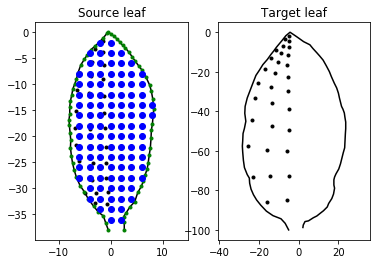

In [5]:
###############################################################################
# Plot everything.
#

plt.subplot(1, 2, 1)
plt.title("Source leaf")
plt.plot(dots_source[:, 0].numpy(), dots_source[:, 1].numpy(), '.', color='black')
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), color='black')
plt.plot(points_imp0[:, 0].numpy(), points_imp0[:, 1].numpy(), '.', color='green')
plt.plot(points_growth[:, 0].numpy(), points_growth[:, 1].numpy(), 'o', color='blue')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title("Target leaf")
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), color='black')
plt.plot(dots_target[:, 0].numpy(), dots_target[:, 1].numpy(), '.', color='black')
plt.axis('equal')

plt.show()

In [6]:
###############################################################################
# We now build the implicit module that will model the growth.
#
# Since we will be learning its growth constants, we need to set its
# `requires_grad` flag to `True`.
#

nu = 0.001
coeff_growth = 1.
scale_growth = 15.

global_translation = dm.DeformationModules.GlobalTranslation(2)

C = torch.ones(points_growth.shape[0], 2, 1)

growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth.clone().requires_grad_(),
        rot_growth.clone().requires_grad_()))

In [7]:
###############################################################################
# Quadratic model for the growing constants.
#

# The polynomial model we will try to fit on our deformation constants
def pol_order_2(pos, a, b, c, d, e, f):
    return a + b*pos[:, 0] + c*pos[:, 1] + d*pos[:, 0]**2 + e*pos[:, 1]**2 + f*pos[:, 0]*pos[:, 1]
def pol_order_2_fromabc(pos, abc):
    a = abc[0].unsqueeze(1)
    b = abc[1].unsqueeze(1)
    c = abc[2].unsqueeze(1)
    d = abc[3].unsqueeze(1)
    e = abc[4].unsqueeze(1)
    f = abc[5].unsqueeze(1)
    return a + b*pos[:, 0] + c*pos[:, 1] + d*pos[:, 0]**2 + e*pos[:, 1]**2 + f*pos[:, 0]*pos[:, 1]

# Initial parameters of our model
abc = torch.zeros(6, 2)
abc[0] = torch.ones(2)
initial_abc = abc.clone().detach()
abc.requires_grad_()

# Callback called when evaluating the model.
# Serves as glue for our model of deformation constants.
def callback_compute_c(init_manifold, modules, parameters):
    abc = parameters['abc']['params'][0]
    a = abc[0].unsqueeze(1)
    b = abc[1].unsqueeze(1)
    c = abc[2].unsqueeze(1)
    d = abc[3].unsqueeze(1)
    e = abc[4].unsqueeze(1)
    f = abc[5].unsqueeze(1)
    modules[3]._ImplicitModule1Base__C = pol_order_2(
        init_manifold[3].gd[0], a, b, c, d, e, f).transpose(0, 1).unsqueeze(2)

In [8]:
# The polynomial model we will try to fit on our deformation constants, 
# Here we assume that the growth parameters only depends on the vertical axis
def pol_order_2(pos, a, b, c, e):
    return a + b * pos[:,0]**2 + c*pos[:, 1] + e*pos[:, 1]**2 
def pol_order_2_fromabc(pos, abc):
    a = abc[0].unsqueeze(1)
    b = abc[1].unsqueeze(1)
    c = abc[2].unsqueeze(1)
    e = abc[3].unsqueeze(1)
    return a + b * pos[:,0]**2 + c*pos[:, 1] + e*pos[:, 1]**2 

# Initial parameters of our model
#abc = -50. + 100*torch.rand(3, 2)
abc = torch.zeros(4, 2)
abc[0] = torch.ones(2)
initial_abc = abc.clone().detach()
abc.requires_grad_()

# Callback called when evaluating the model.
# Serves as glue for our model of deformation constants.
def callback_compute_c(init_manifold, modules, parameters):
    abc = parameters['abc']['params'][0]
    a = abc[0].unsqueeze(1)
    b = abc[1].unsqueeze(1)
    c = abc[2].unsqueeze(1)
    d = abc[3].unsqueeze(1)
    modules[3]._ImplicitModule1Base__C = pol_order_2(
        init_manifold[3].gd[0], a, b, c, d).transpose(0, 1).unsqueeze(2)

In [9]:
print(initial_abc)

tensor([[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


In [10]:


initial_C = pol_order_2_fromabc(points_growth.detach(),
                        initial_abc).transpose(0, 1).unsqueeze(2)

print("Initial growth constants model parameters:")
print(initial_abc)

#f = plt.figure(figsize=(15,15))
#ax = f.add_subplot(1,2,1)
#dm.Utilities.plot_C_arrows(ax, points_growth, initial_C, R=rot_growth, scale=0.001, mutation_scale=8.)
#plt.plot(init_growth.detach().numpy()[:,0], init_growth.detach().numpy()[:,1], '.')
#dm.Utilities.plot_C_ellipses(ax, init_growth, initial_C, R=init_growth_rot, scale=0.003)

#plt.axis(aabb_source.squared().totuple())
#plt.axis('equal')


Initial growth constants model parameters:
tensor([[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


In [11]:
C_normalized = initial_C/torch.norm(initial_C)

In [12]:
deformable_shape_source = dm.Models.DeformablePoints(shape_source)
deformable_shape_target = dm.Models.DeformablePoints(shape_target)
deformable_dots_source = dm.Models.DeformablePoints(dots_source)
deformable_dots_target = dm.Models.DeformablePoints(dots_target)


In [13]:
###############################################################################
# We now define the model. We set the model parameters as an other parameter
# so that it also get learned.
#

model = dm.Models.RegistrationModel([deformable_shape_source, deformable_dots_source], [global_translation, growth, implicit0], [dm.Attachment.VarifoldAttachment(2, [10., 50., 100]), dm.Attachment.EuclideanPointwiseDistanceAttachment(100.)], lam=10., other_parameters={'abc': {'params': [abc]}}, precompute_callback=callback_compute_c)

In [14]:
###############################################################################
# Fitting.
#

shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
fitter.fit([deformable_shape_target, deformable_dots_target], 500, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(873465.)}
Time: 80.20418080500531
Iteration: 0
Costs
deformation=35.57097244262695
attach=698937.5625
Total cost=698973.1334724426
Time: 167.63950041300268
Iteration: 1
Costs
deformation=37.25529479980469
attach=680825.625
Total cost=680862.8802947998
Time: 250.8126005630038
Iteration: 2
Costs
deformation=1573.21044921875
attach=193146.71875
Total cost=194719.92919921875
Time: 325.61297937600466
Iteration: 3
Costs
deformation=4077.75927734375
attach=86229.8046875
Total cost=90307.56396484375
Time: 405.5669400190018
Iteration: 4
Costs
deformation=3612.5
attach=56383.65234375
Total cost=59996.15234375
Time: 515.0352738680012
Iteration: 5
Costs
deformation=2971.57861328125
attach=40599.74609375
Total cost=43571.32470703125
Time: 585.2406800669996
Iteration: 6
Costs
deformation=2975.35400390625
attach=40561.609375
Total cost=43536.96337890625
Time: 612.9751055119996
Iteration: 7
Costs
de

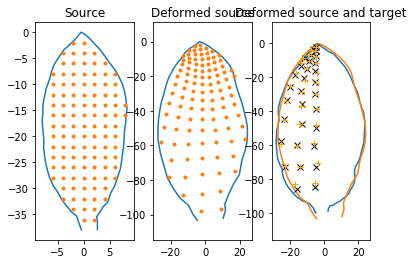

In [15]:
###############################################################################
# Plot matching results.
#

intermediates = {}
model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

intermediate_states = intermediates['states']
deformed_source = intermediate_states[-1][0].gd
deformed_sourcedots = intermediate_states[-1][1].gd
deformed_growth = intermediate_states[-1][3].gd[0]
deformed_growth_rot = intermediate_states[-1][3].gd[1]

aabb_target = dm.Utilities.AABB.build_from_points(shape_target).squared().scale(1.1)

plt.subplot(1, 3, 1)
plt.title("Source")
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), '-')
plt.plot(points_growth[:, 0].numpy(), points_growth[:, 1].numpy(), '.')
plt.axis(aabb_target.totuple())
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.title("Deformed source")
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(deformed_growth[:, 0], deformed_growth[:, 1], '.')
plt.axis(aabb_target.totuple())
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.title("Deformed source and target")
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), '-')
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(dots_target[:, 0].numpy(), dots_target[:, 1].numpy(), 'x', color='black')
plt.plot(deformed_sourcedots[:, 0].numpy(), deformed_sourcedots[:, 1].numpy(), '+', color='orange')
plt.axis(aabb_target.totuple())


plt.axis('equal')
plt.show()



(-31.078314781188965,
 26.996699333190918,
 -108.47369499206543,
 5.165414047241211)

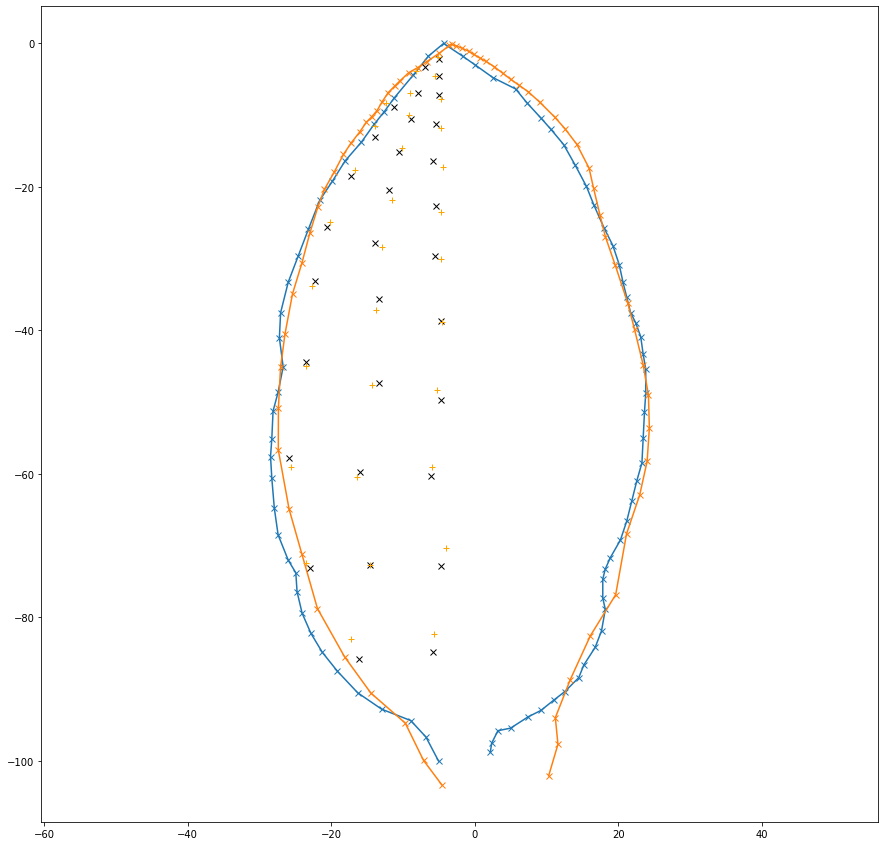

In [16]:
plt.figure(figsize=(15,15))
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), 'x-')
plt.plot(deformed_source[:, 0], deformed_source[:, 1], 'x-')
plt.plot(dots_target[:, 0].numpy(), dots_target[:, 1].numpy(), 'x', color='black')
plt.plot(deformed_sourcedots[:, 0].numpy(), deformed_sourcedots[:, 1].numpy(), '+', color='orange')
plt.axis(aabb_target.totuple())
plt.axis('equal')

In [32]:
len(intermediates['states'])

11

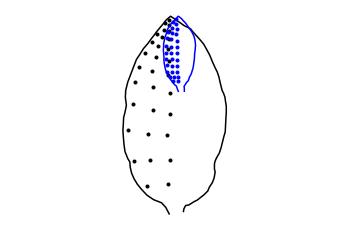

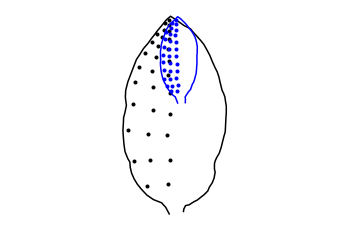

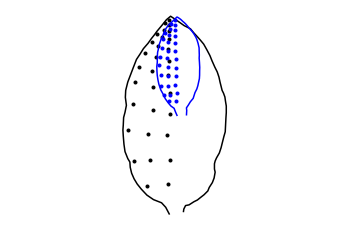

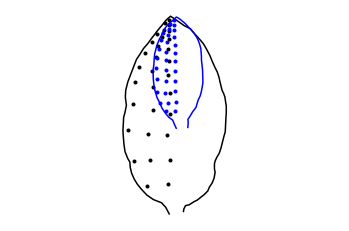

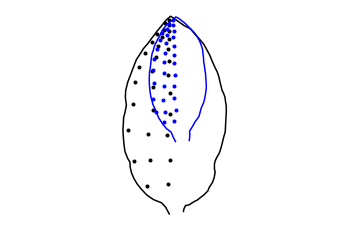

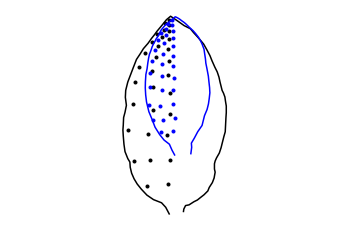

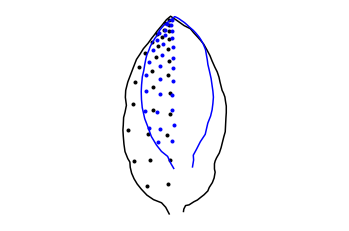

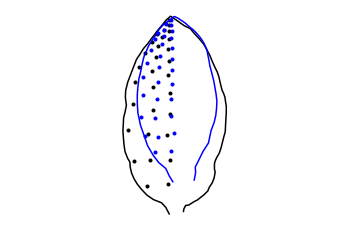

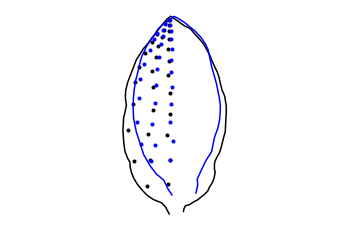

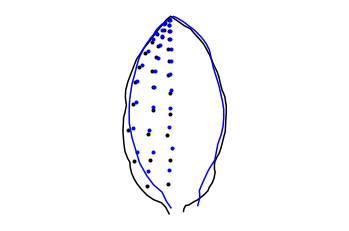

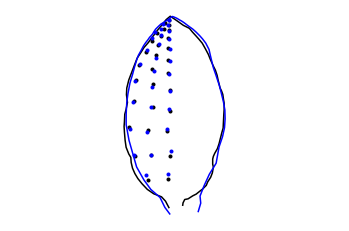

In [36]:

intermediate_states = intermediates['states']
for i in range(11):
    plt.figure()
    deformed_source = intermediate_states[i][0].gd
    deformed_sourcedots = intermediate_states[i][1].gd
    deformed_growth = intermediate_states[i][3].gd[0]
    deformed_growth_rot = intermediate_states[i][3].gd[1]

    #plt.plot(dots_source[:, 0].numpy(), dots_source[:, 1].numpy(), '.', color='blue')
    plt.plot(dots_target[:, 0].numpy(), dots_target[:, 1].numpy(), '.', color='black')
    #plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), '-b')
    plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), '-k')
    plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-b')
    plt.plot(deformed_sourcedots[:, 0].numpy(), deformed_sourcedots[:, 1].numpy(), '.', color='blue')
    plt.axis('equal')
    plt.axis('off')
    plt.savefig('/home/gris/ownCloud/presentations/figuresInria/leaf_defo_t_' + str(i) + '.pdf', format='pdf', bbox_inches = 'tight')

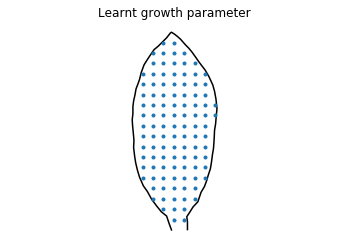

In [29]:
intermediates

{'controls': [[tensor([]),
   tensor([]),
   tensor([ -1.6269, -24.9815]),
   tensor([0.0052]),
   tensor([[  0.0919,  -1.9798],
           [ -0.7721,   3.8977],
           [  0.9637,  -7.2646],
           [ -0.7630,   6.3786],
           [ -0.1355, -10.1031],
           [  0.3414,   8.4188],
           [ -0.9806, -15.0120],
           [  0.3455,   9.4794],
           [ -1.1085,  -4.5724],
           [ -0.4480,  -0.4813],
           [  1.2628,   1.3971],
           [ -4.7619,   1.5626],
           [  5.0089,  -3.2530],
           [ -5.7618,   3.6216],
           [  1.1482,   0.6314],
           [ -0.8653,   1.0375],
           [  1.9829,  -4.7978],
           [ -5.2832,   9.3681],
           [  3.4872,  -5.2042],
           [ -0.0257,  -0.6181],
           [ -3.6218,   6.5212],
           [  2.2326,  -5.0558],
           [  0.8273,   0.3858],
           [ -1.9417,   2.6776],
           [ -0.7765,  -1.5109],
           [  2.0284,  -0.3983],
           [ -2.1056,   0.6522],
           [ 

Initial growth constants model parameters:
tensor([[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
Learned growth constants model parameters:
tensor([[  2.4364,   0.6458],
        [ -1.0822,   0.4259],
        [-17.0449, -12.4961],
        [ -0.0862,   0.0783]])


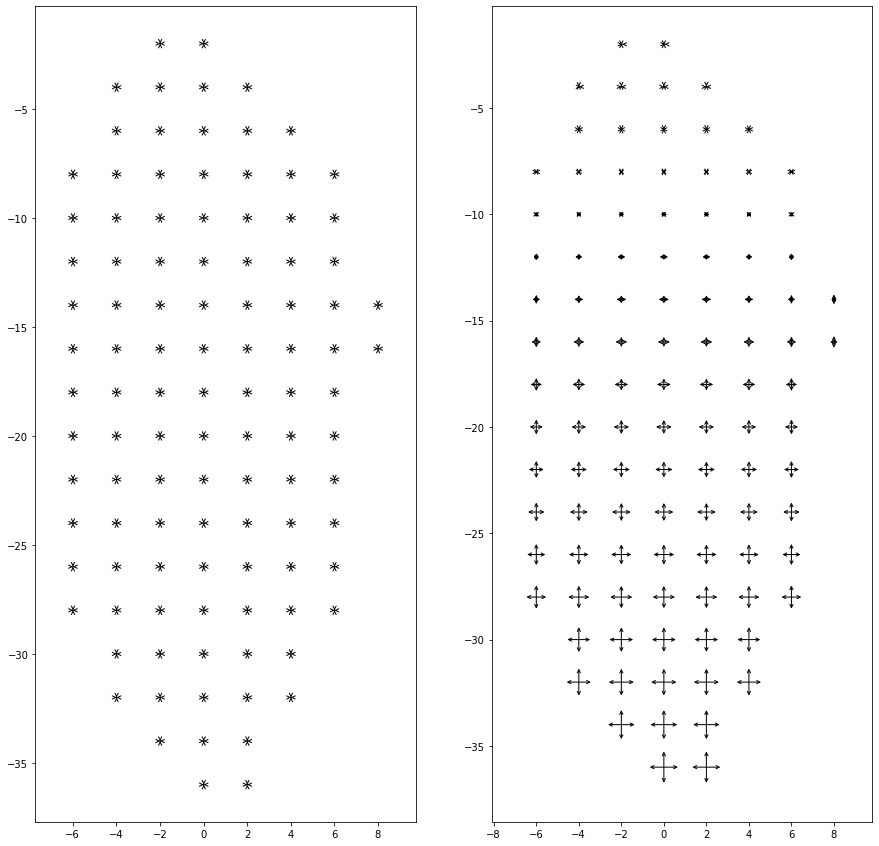

In [18]:

###############################################################################
# Evaluate and plot learned growth constants. We see more growth at the basis
# than at the apex: this is basipetal growth.
#

init_growth = intermediate_states[0][3].gd[0]
init_growth_rot = intermediate_states[0][3].gd[1]


initial_C = pol_order_2_fromabc(init_growth.detach(),
                        initial_abc).transpose(0, 1).unsqueeze(2)

print("Initial growth constants model parameters:")
print(initial_abc)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(1,2,1)
dm.Utilities.plot_C_arrows(ax, init_growth, initial_C, R=init_growth_rot, scale=0.003, mutation_scale=8.)
#plt.plot(init_growth.detach().numpy()[:,0], init_growth.detach().numpy()[:,1], '.')
#dm.Utilities.plot_C_ellipses(ax, init_growth, initial_C, R=init_growth_rot, scale=0.003)

#plt.axis(aabb_source.squared().totuple())
plt.axis('equal')


init_growth = intermediate_states[0][3].gd[0]
init_growth_rot = intermediate_states[0][3].gd[1]
learned_abc = abc.detach()
learned_C = pol_order_2_fromabc(init_growth.detach(),
                        learned_abc).transpose(0, 1).unsqueeze(2)

print("Learned growth constants model parameters:")
print(learned_abc)

ax2 = f.add_subplot(1,2,2)
dm.Utilities.plot_C_arrows(ax2, init_growth, learned_C, R=init_growth_rot, scale=0.003, mutation_scale=8.)
#plt.plot(init_growth.detach().numpy()[:,0], init_growth.detach().numpy()[:,1], '.')
#dm.Utilities.plot_C_ellipses(ax2, init_growth, learned_C, R=init_growth_rot, scale=0.0005)
#plt.axis(aabb_source.squared().totuple())
plt.axis('equal')
plt.show()



In [19]:
load_res = pickle.load( open( "/home/gris/Results/ImplicitModules/Leaf/model_learntfromuniform.p", "rb" ) )

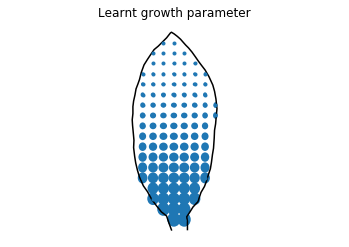

In [39]:
f = plt.figure()
ax = f.add_subplot(1,1,1)

plt.title('Learnt growth parameter')
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), color='black')
#dm.Utilities.plot_C_arrows(ax, points_growth, initial_C, R=rot_growth, scale=2.5, mutation_scale=8.)
plt.plot(points_growth.detach().numpy()[:,0], points_growth.detach().numpy()[:,1], '.')
dm.Utilities.plot_C_ellipses(ax, points_growth, learned_C, R=rot_growth, scale=0.005)
plt.axis('equal')
plt.axis('off')
plt.savefig('/home/gris/ownCloud/presentations/figuresInria/leaf_source_learntC.pdf', format='pdf', bbox_inches = 'tight')

In [20]:
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)

intermediates = {}
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(modules), shoot_solver, shoot_it, intermediates=intermediates)

intermediate_states = intermediates['states']
intermediate_controls = intermediates['controls']

ss_controls = [control[4] for control in intermediate_controls]
growth_controls = [control[3] for control in intermediate_controls]


In [30]:
modules.modules

In [21]:
# We extract the modules of the models and fill the right manifolds.
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)
silent = copy.copy(modules[0])
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(shape_source).scale(1.2), [32, 32])
small_scale = copy.copy(modules[4])

# We construct the controls list we will give will shooting
controls = [[torch.tensor([]), torch.tensor([]), control] for control in ss_controls]

dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([silent, deformation_grid, small_scale]), shoot_solver, shoot_it, controls=controls)

ss_deformed_source = silent.manifold.gd.detach()
ss_deformed_grid = deformation_grid.togrid()


In [22]:
# We extract the modules of the models and fill the right manifolds.
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)
silent = copy.copy(modules[0])
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(shape_source).scale(1.2), [32, 32])
growth = copy.copy(modules[3])

# We construct the controls list we will give will shooting
controls = [[torch.tensor([]), torch.tensor([]), control] for control in growth_controls]

dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([silent, deformation_grid, growth]), shoot_solver, shoot_it, controls=controls)

growth_deformed_source = silent.manifold.gd.detach()
growth_deformed_grid = deformation_grid.togrid()

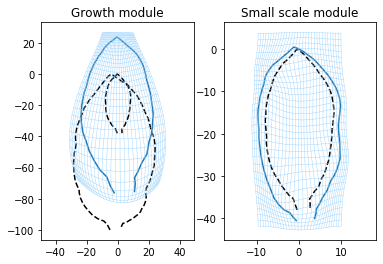

In [23]:
ax = plt.subplot(1, 2, 1)
plt.title("Growth module")
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), '--', color='black')
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), '--', color='black')
plt.plot(growth_deformed_source[:, 0].numpy(), growth_deformed_source[:, 1].numpy())
dm.Utilities.plot_grid(ax, growth_deformed_grid[0], growth_deformed_grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')

ax = plt.subplot(1, 2, 2)
plt.title("Small scale module")
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), '--', color='black')
plt.plot(ss_deformed_source[:, 0].numpy(), ss_deformed_source[:, 1].numpy())
dm.Utilities.plot_grid(ax, ss_deformed_grid[0], ss_deformed_grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')

plt.show()

In [17]:
C_saved = load_res['learntC']

In [21]:
initial_C_saved = load_res['initialC']

In [23]:
initial_C_saved_n = initial_C_saved / torch.norm(initial_C_saved)

In [22]:
C_saved_n = C_saved / torch.norm(C_saved)
C_saved_normalized = C_saved / torch.norm(C_saved)
C_n = learned_C / torch.norm(learned_C)

print(1 - torch.sum(C_saved_n * C_n))

tensor(0.0119, grad_fn=<RsubBackward1>)


In [56]:

print("Initial growth constants model parameters:")
print(initial_abc)

print("Learned growth constants model parameters:")
print(learned_abc)


Initial growth constants model parameters:
tensor([[-0.6465,  0.0281],
        [-0.8098, -0.8367],
        [-0.5113,  0.7962]])
Learned growth constants model parameters:
tensor([[  -0.7439,   -0.5971],
        [   2.2026,    9.8829],
        [-118.5648, -160.7611]])


In [66]:
learned_C2 = pol_order_2_fromabc(model.init_manifold.manifolds[3].gd[0], learned_abc).transpose(0, 1).unsqueeze(2)

In [67]:
learned_C2 - learned_C

tensor([[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        

In [57]:
C_normalized = learned_C/torch.norm(learned_C)

In [40]:
C_save_normalized = learned_C_save/torch.norm(learned_C_save)

In [61]:
abs(torch.sum(C_normalized*C_save_normalized)) - 1

tensor(-0.0249)

In [44]:
C_normalized - C_save_normalized

tensor([[[-0.0074],
         [ 0.0124]],

        [[-0.0118],
         [ 0.0069]],

        [[-0.0155],
         [ 0.0020]],

        [[-0.0184],
         [-0.0021]],

        [[-0.0206],
         [-0.0054]],

        [[-0.0219],
         [-0.0081]],

        [[-0.0226],
         [-0.0101]],

        [[-0.0224],
         [-0.0113]],

        [[-0.0215],
         [-0.0119]],

        [[-0.0198],
         [-0.0117]],

        [[-0.0174],
         [-0.0108]],

        [[ 0.0038],
         [ 0.0256]],

        [[-0.0022],
         [ 0.0187]],

        [[-0.0074],
         [ 0.0124]],

        [[-0.0118],
         [ 0.0069]],

        [[-0.0155],
         [ 0.0020]],

        [[-0.0184],
         [-0.0021]],

        [[-0.0206],
         [-0.0054]],

        [[-0.0219],
         [-0.0081]],

        [[-0.0226],
         [-0.0101]],

        [[-0.0224],
         [-0.0113]],

        [[-0.0215],
         [-0.0119]],

        [[-0.0198],
         [-0.0117]],

        [[-0.0174],
         [-0.0

In [36]:
n_exp = 10
diffs = []
initial_diffs = []
initial_abcs = []
learned_abcs = []
for i_exp in range(n_exp):
    data = pickle.load(open("../../data/basipetal.pkl", 'rb'))

    height_source = 38.
    height_target = 100.

    dots_source = torch.tensor(data['source_d'], dtype=torch.get_default_dtype())
    dots_target = torch.tensor(data['target_d'], dtype=torch.get_default_dtype())
    shape_source = torch.tensor(data['source_c'], dtype=torch.get_default_dtype())
    shape_target = torch.tensor(data['target_c'], dtype=torch.get_default_dtype())

    smin, smax = torch.min(shape_source[:, 1]), torch.max(shape_source[:, 1])
    sscale = height_source / (smax - smin)
    dots_source[:, 1] =  sscale * (dots_source[:, 1] - smax)
    dots_source[:, 0] = sscale * (dots_source[:, 0] - torch.mean(shape_source[:, 0]))
    shape_source[:, 1] =  sscale * (shape_source[:, 1] - smax)
    shape_source[:, 0] = sscale * (shape_source[:, 0] - torch.mean(shape_source[:, 0]))

    tmin, tmax = torch.min(shape_target[:, 1]), torch.max(shape_target[:, 1])
    tscale = height_target / (tmax - tmin)
    dots_target[:, 1] =  tscale * (dots_target[:, 1] - tmax)
    dots_target[:, 0] = tscale * (dots_target[:, 0] - torch.mean(shape_target[:, 0]))
    shape_target[:, 1] =  tscale * (shape_target[:, 1] - tmax)
    shape_target[:, 0] = tscale * (shape_target[:, 0] - torch.mean(shape_target[:, 0]))

    ###############################################################################
    # We now sample the points that will be used by the deformation modules.
    #

    # Build AABB around the source shape and uniformly sample points for the implicit
    # module of order 1
    aabb_source = dm.Utilities.AABB.build_from_points(shape_source)
    points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 0.25, shape=shape_source)

    rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

    ###############################################################################
    # We now build the implicit module that will model the growth.
    #
    # Since we will be learning its growth constants, we need to set its
    # `requires_grad` flag to `True`.
    #

    nu = 0.001
    coeff_growth = 1.
    scale_growth = 25.

    global_translation = dm.DeformationModules.GlobalTranslation(2)

    C = torch.zeros(points_growth.shape[0], 2, 1)

    growth = dm.DeformationModules.ImplicitModule1(
        2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
        gd=(points_growth.clone().requires_grad_(),
            rot_growth.clone().requires_grad_()))
    # The polynomial model we will try to fit on our deformation constants, 
    # Here we assume that the growth parameters only depends on the vertical axis
    def pol_order_2(pos, a, c, e):
        return a + c*pos[:, 1] + e*pos[:, 1]**2 
    def pol_order_2_fromabc(pos, abc):
        a = abc[0].unsqueeze(1)
        c = abc[1].unsqueeze(1)
        e = abc[2].unsqueeze(1)
        return a + c*pos[:, 1] + e*pos[:, 1]**2 

    # Initial parameters of our model
    abc = -1. + 2*torch.rand(3, 2)
    #abc = torch.zeros(6, 2)
    #abc[0] = torch.ones(2)
    initial_abcs.append(abc.clone().detach())
    abc.requires_grad_()
    initial_C = pol_order_2(
            points_growth, abc[0].unsqueeze(1), abc[1].unsqueeze(1), abc[2].unsqueeze(1)).transpose(0, 1).unsqueeze(2)
    initial_diffs.append(abs(torch.sum( (initial_C/torch.norm(initial_C) )* initial_C_saved_n)).item() - 1)
    # Callback called when evaluating the model.
    # Serves as glue for our model of deformation constants.
    def callback_compute_c(init_manifold, modules, parameters):
        abc = parameters['abc']['params'][0]
        a = abc[0].unsqueeze(1)
        b = abc[1].unsqueeze(1)
        c = abc[2].unsqueeze(1)
        modules[3]._ImplicitModule1Base__C = pol_order_2(
            init_manifold[3].gd[0], a, b, c).transpose(0, 1).unsqueeze(2)

    deformable_shape_source = dm.Models.DeformablePoints(shape_source)
    deformable_shape_target = dm.Models.DeformablePoints(shape_target)
    deformable_dots_source = dm.Models.DeformablePoints(dots_source)
    deformable_dots_target = dm.Models.DeformablePoints(dots_target)
    ###############################################################################
    # We now define the model. We set the model parameters as an other parameter
    # so that it also get learned.
    #

    model = dm.Models.RegistrationModel([deformable_shape_source, deformable_dots_source], [global_translation, growth], [dm.Attachment.VarifoldAttachment(2, [5., 25, 80.]), dm.Attachment.EuclideanPointwiseDistanceAttachment(500.)], lam=100., other_parameters={'abc': {'params': [abc]}}, precompute_callback=callback_compute_c)

    shoot_solver = 'euler'
    shoot_it = 10

    costs = {}
    fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
    fitter.fit([deformable_shape_target, deformable_dots_target], 500, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

    learned_abc = abc.detach()
    learned_abcs.append(learned_abc.clone().detach())
    learned_C = pol_order_2_fromabc(model.init_manifold.manifolds[3].gd[0], learned_abc).transpose(0, 1).unsqueeze(2)
    C_normalized = learned_C/torch.norm(learned_C)
    diffs.append(abs(torch.sum(C_normalized*C_saved_n)).item() - 1)
    print('------------------' + str(i_exp) + '------' + str(abs(torch.sum(C_normalized*C_saved_n)) - 1) + '------' + initial_diffs[-1])

Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(31961600.)}
Time: 63.5784562230001
Iteration: 0
Costs
deformation=16613.529296875
attach=21954872.0
Total cost=21971485.529296875
Time: 141.90306795700235
Iteration: 1
Costs
deformation=30001.771484375
attach=4601070.0
Total cost=4631071.771484375
Time: 218.736011969002
Iteration: 2
Costs
deformation=19254.89453125
attach=3633017.25
Total cost=3652272.14453125
Time: 299.8721200120017
Iteration: 3
Costs
deformation=9847.9306640625
attach=2823445.0
Total cost=2833292.9306640625


KeyboardInterrupt: 

In [35]:
print('------------------' + str(i_exp) + '------' + str(abs(torch.sum(C_normalized*C_saved_n)) - 1) + '------' + str(initial_diffs[-1]))

------------------0------tensor(-0.0118, grad_fn=<SubBackward0>)-------0.25092238187789917


In [30]:
abs(torch.sum(C_normalized*C_saved_n)).item() - 1

-0.011845231056213379

In [32]:
initial_diffs[-1]

-0.25092238187789917

In [29]:
diffs

[tensor(-0.0118, grad_fn=<SubBackward0>)]

In [80]:
C_normalized = learned_C/torch.norm(learned_C)

In [82]:
C_normalized*C_save_normalized

tensor([[[-8.1307e-03],
         [-9.9936e-03]],

        [[-7.1005e-03],
         [-8.0964e-03]],

        [[-6.1255e-03],
         [-6.4691e-03]],

        [[-5.2095e-03],
         [-5.0866e-03]],

        [[-4.3563e-03],
         [-3.9250e-03]],

        [[-3.5695e-03],
         [-2.9612e-03]],

        [[-2.8524e-03],
         [-2.1738e-03]],

        [[-2.2084e-03],
         [-1.5421e-03]],

        [[-1.6407e-03],
         [-1.0468e-03]],

        [[-1.1524e-03],
         [-6.6969e-04]],

        [[-7.4635e-04],
         [-3.9368e-04]],

        [[-1.0341e-02],
         [-1.4704e-02]],

        [[-9.2122e-03],
         [-1.2187e-02]],

        [[-8.1307e-03],
         [-9.9936e-03]],

        [[-7.1005e-03],
         [-8.0964e-03]],

        [[-6.1255e-03],
         [-6.4691e-03]],

        [[-5.2095e-03],
         [-5.0866e-03]],

        [[-4.3563e-03],
         [-3.9250e-03]],

        [[-3.5695e-03],
         [-2.9612e-03]],

        [[-2.8524e-03],
         [-2.1738e-03]],



In [71]:
print([di.item() for di in diffs])

[-0.024793505668640137, -0.024477899074554443, -0.0020981431007385254, -0.0021457672119140625, -0.002099931240081787, -0.0021022558212280273, -0.002097606658935547, -0.0021126270294189453, -0.024785876274108887, nan, -0.024847090244293213, -0.024587035179138184, -0.0021088719367980957, -0.002095341682434082, -0.0020914077758789062, -0.002096831798553467, -0.0020914077758789062, -0.002101421356201172, -0.0020992159843444824, -0.024812519550323486, -0.024890661239624023, -0.0020874738693237305, -0.0021019577980041504, -0.0021039247512817383, -0.02477043867111206, -0.002097606658935547, -0.024789392948150635, -0.002034008502960205, -0.024642884731292725, -0.02483469247817993, -0.02481299638748169, -0.024770677089691162, -0.0020974278450012207, -0.002103745937347412, -0.002110719680786133, -0.024673819541931152, nan, -0.024875104427337646, -0.021198391914367676, nan, -0.002113521099090576]


In [73]:
C_save_normalized.shape

torch.Size([105, 2, 1])

In [74]:
torch.norm(learned_C)

tensor(3131.2053, grad_fn=<NormBackward0>)

In [78]:
torch.sum(C_save_normalized**2)

tensor(1.0000)

In [19]:

print("Initial growth constants model parameters:")
print(initial_abc)

print("Learned growth constants model parameters:")
print(learned_abc)

print("Learned growth parameter:")
print(learned_C_save)


Initial growth constants model parameters:
tensor([[1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
Learned growth constants model parameters:
tensor([[-1.5216e+00, -7.2023e-02],
        [-9.5480e+01, -6.7221e+01],
        [ 3.4804e-01,  1.7700e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]])
Learned growth parameter:
tensor([[[2944.7891],
         [3269.7671]],

        [[2716.2400],
         [2944.1699]],

        [[2490.4753],
         [2632.7319]],

        [[2267.4949],
         [2335.4541]],

        [[2047.2991],
         [2052.3354]],

        [[1829.8875],
         [1783.3765]],

        [[1615.2603],
         [1528.5771]],

        [[1403.4172],
         [1287.9374]],

        [[1194.3588],
         [1061.4572]],

        [[ 988.0844],
         [ 849.1367]],

        [[ 784.5945],
         [ 650.9757]],

        [[3410.2402],
         [3963.4409]],

        [[

In [16]:

print("Initial growth constants model parameters:")
print(initial_abc)

print("Learned growth constants model parameters:")
print(learned_abc)


Initial growth constants model parameters:
tensor([[1., 1.],
        [0., 0.],
        [0., 0.]])
Learned growth constants model parameters:
tensor([[-1.5216e+00, -7.2023e-02],
        [-9.5480e+01, -6.7221e+01],
        [ 3.4804e-01,  1.7700e+00]])


In [23]:
load_res = pickle.load( open( "/home/gris/Results/ImplicitModules/Leaf/model_learntfromuniform.p", "rb" ) )

In [24]:
model = load_res['model']

In [ ]:
###############################################################################
# Plot matching results.
#

intermediates = {}
model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

intermediate_states = intermediates['states']
deformed_source = intermediate_states[-1][0].gd
deformed_sourcedots = intermediate_states[-1][1].gd
deformed_growth = intermediate_states[-1][3].gd[0]
deformed_growth_rot = intermediate_states[-1][3].gd[1]

aabb_target = dm.Utilities.AABB.build_from_points(shape_target).squared().scale(1.1)

In [ ]:
plt.subplot(1, 3, 1)
plt.title("Source")
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), '-')
plt.plot(points_growth[:, 0].numpy(), points_growth[:, 1].numpy(), '.')
plt.axis(aabb_target.totuple())
plt.axis('equal')

In [ ]:
plt.subplot(1, 3, 2)
plt.title("Deformed source")
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(deformed_growth[:, 0], deformed_growth[:, 1], '.')
plt.axis(aabb_target.totuple())
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.title("Deformed source and target")
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), '-')
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(dots_target[:, 0].numpy(), dots_target[:, 1].numpy(), 'x', color='black')
plt.plot(deformed_sourcedots[:, 0].numpy(), deformed_sourcedots[:, 1].numpy(), '+', color='orange')
plt.axis(aabb_target.totuple())


plt.axis('equal')
plt.show()